# FitzHugh-Nagumo analysis

The FitzHugh-Nagumo model is given by:

$$ \frac {dV} {dt} = V(1 - \frac {V^2} 3) - w + I_{ext} $$

$$ \tau \frac {dw} {dt} = V + a - b w $$

In [1]:
import brainpy as bp
import numpy as np

bp.profile.set(backend='numpy',dt=0.02, numerical_method='rk4')

In [2]:
def get_model(a=0.7, b=0.8, tau=12.5, Vth=1.9):
    state = bp.types.NeuState({'v': 0., 'w': 1., 'spike': 0., 'input': 0.})

    @bp.integrate
    def int_w(w, t, v):
        return (v + a - b * w) / tau

    @bp.integrate
    def int_v(v, t, w, Iext):
        return v - v * v * v / 3 - w + Iext

    def update(ST, _t_):
        ST['w'] = int_w(ST['w'], _t_, ST['v'])
        v = int_v(ST['v'], _t_, ST['w'], ST['input'])
        ST['spike'] = np.logical_and(v >= Vth, ST['v'] < Vth)
        ST['v'] = v
        ST['input'] = 0.

    return bp.NeuType(name='FitzHugh_Nagumo',
                      requires=dict(ST=state),
                      steps=update)

### Simulation

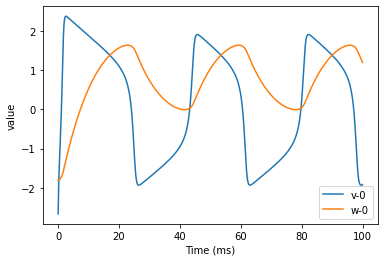

In [3]:
neuron = get_model()
group = bp.NeuGroup(neuron, 1, monitors=['v', 'w'])
group.ST['v'] = -2.8
group.ST['w'] = -1.8
group.run(100., inputs=('ST.input', 0.8))
bp.visualize.line_plot(group.mon.ts, group.mon.v, legend='v', )
bp.visualize.line_plot(group.mon.ts, group.mon.w, legend='w', show=True)

### Phase plane analysis

Fixed point #1 at v=-0.2729009589972752, w=0.5338738012534059 is a unstable-node.


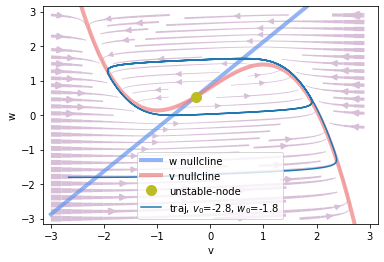

In [4]:
analyzer = bp.PhasePortraitAnalyzer(
    model=neuron,
    target_vars={'v': [-3, 3], 'w': [-3., 3.]},
    fixed_vars={'Iext': 0.8})
analyzer.plot_nullcline()
analyzer.plot_vector_filed()
analyzer.plot_fixed_point()
analyzer.plot_trajectory([(-2.8, -1.8, 100.)],
                         inputs=('ST.input', 0.8),
                         show=True)

### Codimension 1 bifurcation analysis

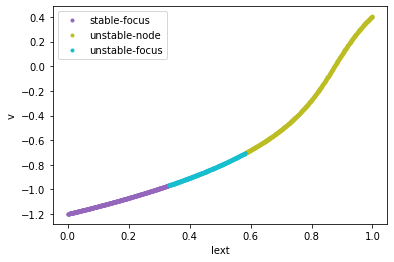

In [5]:
analyzer = bp.BifurcationAnalyzer(
    model=neuron,
    target_pars={'Iext': [0., 1.]},
    dynamical_vars={'v': [-3, 3], 'w': [-3., 3.]},
    par_resolution=0.001,
)
analyzer.plot_bifurcation(plot_vars=['v'], show=True)

### Codimension 2 bifurcation analysis

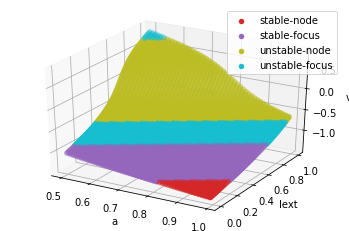

In [6]:
analyzer = bp.BifurcationAnalyzer(
    model=neuron,
    target_pars={'a': [0.5, 1.], 'Iext': [0., 1.]},
    dynamical_vars={'v': [-3, 3], 'w': [-3., 3.]},
    par_resolution=0.01,
)
analyzer.plot_bifurcation(plot_vars=['v'], show=True)